In [ ]:
!pip install keras_applications

In [1]:
from numpy import load 
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from os import name
from keras.layers import Concatenate
from keras import applications
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import optimizers
from keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
NAME="DenseNet Lead aVR-{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [3]:
Log_dir = 'logs/fit/{}'.format(NAME)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=Log_dir, histogram_freq=1)

In [4]:
data = load('F:/denoised/aVR_128.npz', allow_pickle=True)

In [5]:
train_X = data['X_train'] 
print('Loaded: ', train_X.shape)

Loaded:  (8516, 128, 128, 3)


In [6]:
test_X = data['X_test'] 
print('Loaded: ', test_X.shape)

Loaded:  (2130, 128, 128, 3)


In [7]:
train_y = data['y_train']
print('Loaded: ', train_y.shape) 

Loaded:  (8516, 1)


In [8]:
test_y = data['y_test']
print('Loaded: ', test_y.shape) 

Loaded:  (2130, 1)


In [9]:
data=load("F:/denoised/split/I/mlp/train_X_dia.npz")
mlp_train_X=data['arr_0']
print('loaded', mlp_train_X.shape)

loaded (8516, 11)


In [10]:
data=load("F:/denoised/split/I/mlp/train_y_dia.npz")
mlp_test_X=data['arr_0']
print('loaded', mlp_test_X.shape)

loaded (2130, 11)


In [11]:
training_data = np.vsplit(train_X, 1) 

In [12]:
for i in range(1):
    print(training_data[i].shape) 

(8516, 128, 128, 3)


In [13]:
np.shape(training_data)

(1, 8516, 128, 128, 3)

In [14]:
testing_data = np.vsplit(test_X, 1) 

In [15]:
for i in range(1):
    print(testing_data[i].shape)

(2130, 128, 128, 3)


In [16]:
np.shape(testing_data) 

(1, 2130, 128, 128, 3)

In [17]:
train_y=pd.DataFrame(train_y, columns=[ 'Rhythm'])
test_y=pd.DataFrame(test_y, columns=[ 'Rhythm'])

In [18]:
label = LabelEncoder()
train_y['label'] = label.fit_transform(train_y['Rhythm'])

In [19]:
test_y['label'] = label.fit_transform(test_y['Rhythm'])

In [20]:
train_y=train_y.drop([ 'Rhythm'], axis=1)
test_y=test_y.drop([ 'Rhythm'], axis=1)

In [21]:
y_train=to_categorical(train_y) 
y_test=to_categorical(test_y) 

In [22]:
base_model=tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3)
)

In [23]:
base_model.trainable = False

In [24]:
# dataset has 4 classes
num_class = 4

In [25]:
def conv_block_2d():
        preprocess = tf.keras.layers.experimental.preprocessing.Rescaling(
            scale=1.0/127.5,
            offset=-1)
        inputs = layers.Input(shape=(128, 128, 3))
        x = preprocess(inputs)
        x =base_model(x, training=False)
        output = layers.GlobalAveragePooling2D()(x)
        return inputs, output 

In [26]:
def multiple_cnn2D(nb):
  inputs = []
  features = []
  for i in range(nb):
    input_2d, features_2d = conv_block_2d()
    inputs.append(input_2d)
    features.append(features_2d)

  x1 = layers.concatenate(features, axis=-1)
  x1= Dropout(.1)(x1)
  x1=Dense(32,activation='relu')(x1)
  x1= Dropout(0.2)(x1)

  x2 = Sequential()
  mlp_input = Input(shape=(11,), name='mlp')
  x2=Dense(128, activation='relu')(mlp_input)
  
  concat = layers.concatenate([x1,x2])
  preds=Dense(num_class, activation='softmax')(concat) #final layer with softmax activation
  
  model=Model(inputs=[inputs, mlp_input],outputs=preds)
  opt = Adam(lr=0.00003) 
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  print(model.summary())
  return model

In [27]:
model = multiple_cnn2D(1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 densenet201 (Functional)       (None, 4, 4, 1920)   18321984    ['rescaling[0][0]']              
                                                                                                  
 global_average_pooling2d (Glob  (None, 1920)        0           ['densenet201[0][0]']        

C:\Users\ASUS\.conda\envs\Tensorflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [29]:
callback_list=[early_stopping, tensorboard_callback]

In [30]:
#lead aVR
history = model.fit([training_data, mlp_train_X], y_train, epochs = 430, batch_size=64, validation_data= ([testing_data, mlp_test_X], y_test), callbacks=[callback_list])

Epoch 1/430
134/134 [==============================] - 38s 174ms/step - loss: 1.2131 - accuracy: 0.4439 - val_loss: 0.9988 - val_accuracy: 0.5995
Epoch 2/430
134/134 [==============================] - 18s 132ms/step - loss: 0.9397 - accuracy: 0.6261 - val_loss: 0.8175 - val_accuracy: 0.7127
Epoch 3/430
134/134 [==============================] - 18s 133ms/step - loss: 0.8050 - accuracy: 0.7023 - val_loss: 0.7023 - val_accuracy: 0.7756
Epoch 4/430
134/134 [==============================] - 18s 133ms/step - loss: 0.7071 - accuracy: 0.7578 - val_loss: 0.6224 - val_accuracy: 0.8052
Epoch 5/430
134/134 [==============================] - 18s 134ms/step - loss: 0.6473 - accuracy: 0.7819 - val_loss: 0.5666 - val_accuracy: 0.8296
Epoch 6/430
134/134 [==============================] - 18s 133ms/step - loss: 0.6002 - accuracy: 0.7950 - val_loss: 0.5262 - val_accuracy: 0.8455
Epoch 7/430
134/134 [==============================] - 18s 133ms/step - loss: 0.5620 - accuracy: 0.8133 - val_loss: 0.4941 -

In [31]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

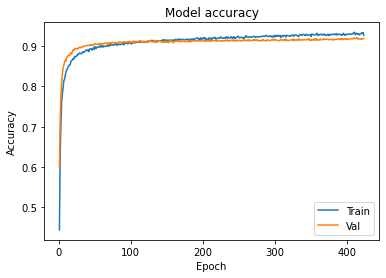

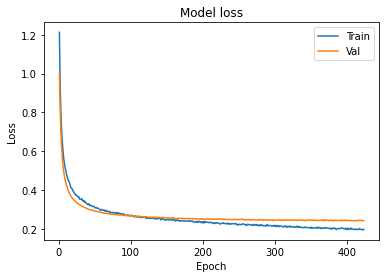

In [32]:
plot_learningCurve(history, 423)

In [33]:
preds = model.predict([testing_data, mlp_test_X])

In [34]:
classes_x=np.argmax(preds,axis=1)
rounded_labels=np.argmax(y_test, axis=1)

In [35]:
import sklearn.metrics as metrics
import seaborn as sns

In [36]:
def confusion_matrix(y, y_pred):
    labels=[ 'AFIB','GSVT', 'SB', 'SR']
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 6))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

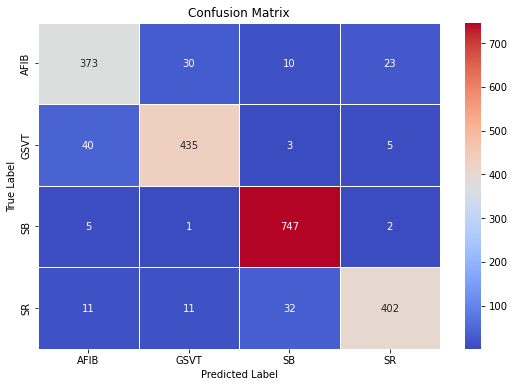

In [37]:
confusion_matrix(rounded_labels, classes_x)

In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(rounded_labels, classes_x))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       436
           1       0.91      0.90      0.91       483
           2       0.94      0.99      0.97       755
           3       0.93      0.88      0.91       456

    accuracy                           0.92      2130
   macro avg       0.91      0.91      0.91      2130
weighted avg       0.92      0.92      0.92      2130



In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit